In [42]:
# %matplotlib inline
#imports
import pandas as pd
from fbprophet import Prophet #used for timer series prediction
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

In [43]:
#reading dataset and creating dataframe
raw_data = pd.read_csv("Online_Retail.csv")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [44]:
#droping unnecessary columns
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])#converting InvoiceDate column into DateTime object
print(sales_data.info())
sales_data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB
None


RangeIndex(start=0, stop=541909, step=1)

In [4]:
stock_codes = list(sales_data.StockCode.unique())#pulling out a list of all unique products

In [5]:
#this function extract all the transactions of one product, convert it to time-series and return
def extract_product(product_id,freq):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling data
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample(freq).sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1 #to avoid -inf while taking log transformation 

#uncomment this block of code for ploting time series 
#     fig, ax1 = plt.subplots()
#     ax1.plot(day_summary.index, day_summary['Quantity'])
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel('Quantity')
#     plt.show()
    return day_summary

In [6]:
def result_analysis(errors):
    errors = [value[1] for value in errors]
    None_count = errors.count(None)
    errors = [x for x in errors if x!=None]
    min_value = min(errors)
    max_value = max(errors)
    avg_value = sum(errors)/len(errors)
#uncomment to print all the stats in more readable fashion, 
#     print("min value = "+str(min_value))
#     print("max value = "+str(max_value))
#     print("avg value = "+str(avg_value))
#     print("none count = "+str(None_count))
    return (min_value,max_value,avg_value)

In [7]:
#calculates root mean squared relative error, not being used in this version of model
def get_rmse_relative_error(y,yhat):
    relative_errors = [(x-y)/x for x,y in zip(y,yhat)]
    root_mean_square_relative_error = np.sqrt(sum([x**2 for x in relative_errors])/len(relative_errors))
    return root_mean_square_relative_error

In [8]:
##calculates mean squared relative error
def get_mean_relative_error(y,yhat):
    relative_error = [abs((x-y)/x) for x,y in zip(y,yhat)]
    mean_relative_error = sum(relative_error)/len(relative_error)
    return mean_relative_error

In [45]:
errors = list() # record of all the products and its error
count =1 #used to print progress
#running prediction for each product, 4070 unique products so it takes couple of hours to complete
for product in stock_codes[:10]:
    print('\r', count, end='')#printing progress
    count+=1
    freq = 'D'#change this to change frequency of downsampling-'D'-for daily data,W'-for weekly data,'M'-for monthly data 
    try:
        day_summary = extract_product(product,freq) #extracting product and downsampling
        # day_summary.head()
        day_summary.reset_index(inplace=True) #resetting index  
        day_summary = day_summary.rename(columns={'Quantity': 'y','InvoiceDate': 'ds'})#changing column names as required by fbprophet
        train,test = day_summary[:int(len(day_summary)*0.9)],day_summary[int(len(day_summary)*0.9):]#test train split
#         print((len(train),len(test),len(day_summary)))
        my_model = Prophet(daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True) #declaring model object
        my_model.fit(train)#traning model
        future_dates = my_model.make_future_dataframe(periods=len(test),freq=freq)#declaring dataframe with future date to do prediction
        forecast = my_model.predict(future_dates)#predicting future demand
        predicted = forecast[['ds', 'yhat']].tail(len(test))#slicing test data
#         errors.append((product,get_rmse_relative_error(test.y,predicted.yhat)))
        errors.append((product,get_mean_relative_error(test.y,predicted.yhat)))# calculating error 
    except:
        errors.append((product,None))
#uncomment below block to plot weekely, daily ,yearly trends and predicted time series
#     my_model.plot(forecast,uncertainty=True);
#     my_model.plot_components(forecast);
#     plt.show();
    
# writting errors to a file, no need to train model every time
with open("result.txt", 'w') as file:
    for item in errors:
        file.write("{}\n".format(item))


 10

In [46]:
errors

[('85123A', 305.98990508468415),
 ('71053', 1.8158217130187115),
 ('84406B', 1.3082381500769134),
 ('84029G', 6.1864034564702655),
 ('84029E', 35.608468797128118),
 ('22752', 1.8357867289486063),
 ('21730', 2.4115628117899828),
 ('22633', 15.338293290358349),
 ('22632', 6.4682132291029122),
 ('84879', 33.583701247737977)]

In [47]:
result_analysis(errors)#calulating basic stats about all the errors

(1.3082381500769134, 305.98990508468415, 41.054639450931596)

In [13]:
errors_df = pd.DataFrame(errors,columns=['StockCode','error'])
# errors_df = errors_df.set_index('StockCode')

In [14]:
errors_df.head()

,StockCode,error
0,85123A,305.989905
1,71053,1.815822
2,84406B,1.308238
3,84029G,6.186403
4,84029E,35.608469


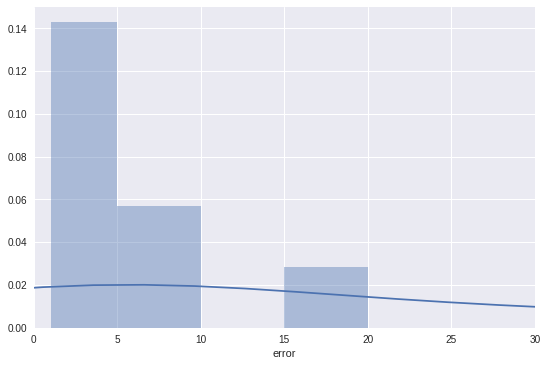

In [15]:
#histogram of error
import seaborn as sns
errors_df.dropna(inplace=True)
sns.distplot(errors_df['error'],bins=[1,5,10,15,20,25])
plt.xlim(0,30)
plt.show()

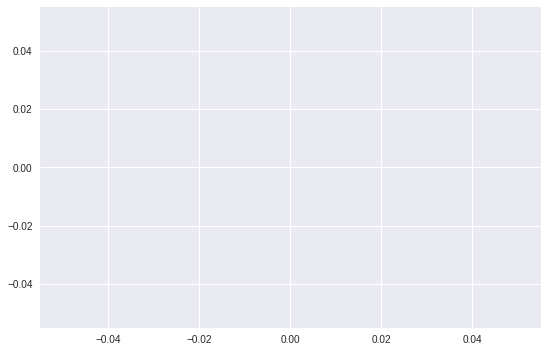

In [16]:
#plot of average mean squared relative erros vs number of products
from random import shuffle
x = range(100,len(errors),100)
for i in range(5):
    y=[]
    shuffle(errors)
    for value in x:
        y.append(result_analysis(errors[:value])[2])
    plt.plot(x, y)
plt.show();

In [41]:
def get_min_price(max_price,min_price,no_of_days):
    historic_data = predicted[:no_of_days]
    pred = predicted['yhat'].iloc[-1]
    max_demand = historic_data.loc[historic_data['yhat'].idxmax()]['yhat']
    min_demand = historic_data.loc[historic_data['yhat'].idxmin()]['yhat']
#     print(max_demand)
#     print(min_demand)
#     print(pred)
    ratio = (pred-min_demand)/(max_demand-min_demand)
    return (ratio*(max_price-min_price))+min_price
get_min_price(100,10,100)

55.957537392594837